In [3]:
import os
import time

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks, optimizers
from keras.utils.vis_utils import plot_model

from lib.data_normalizer import draw_image_with_boxes

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

IMAGE_SHAPE = (227,227)

2022-11-16 22:05:44.169583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 22:05:45.977086: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2022-11-16 22:05:45.977196: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-11-16 22:05:45.990711: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-11-16 22:05:47.735941: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


## Modelo de identificación de placas

In [31]:
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = layers.Input(
    shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    include_top=False,
    weights='imagenet'
    )

# Let's create a function that will construct our model
def create_model(no_of_classes):

    # Freeze the whole model
    N_mobile.trainable = False

    # Start by taking the output feature maps from NASNETMobile
    base_model_output = N_mobile.output

    # Convert to a single-dimensional vector by Global Average Pooling.

    # We could also use Flatten()(x) but GAP is more effective, it reduces
    # Parameters and controls overfitting.
    flattened_output = layers.GlobalAveragePooling2D()(base_model_output)



    # Create Our Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    # Respectively.
    box_output = layers.Dense(256, activation="relu")(flattened_output)
    box_output = layers.Dense(128, activation="relu")(box_output)
    box_output = layers.Dropout(0.2)(box_output )

    box_output = layers.Dense(64, activation="relu")(box_output)
    box_output = layers.Dropout(0.2)(box_output )

    box_output = layers.Dense(32, activation="relu")(box_output)
    box_predictions = layers.Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Now combine the two heads
    model = models.Model(inputs=N_mobile.input, outputs= [box_predictions])

    return model

# Create the model for 1 class
model = create_model(1);
# plot_model(model, to_file='model_plot.png', show_shapes=True,
#            show_layer_names=True)

# Here for each head we will define a different loss, we will define it
# Like a dictionary.

# For classification we will have categorical crossentropy
# For the boundary boxes we will have mean squared error
losses = {
    "box_output": "mean_squared_error"
    }

# Here you can give more or less weight to each loss.

# If you think that detection is harder then the classification then you can
# Try assigning it more weight
loss_weights = {
    "box_output": 1.0
}

# Set the Metrics
# For the class labels we want to know the Accuracy
# And for the bounding boxes we need to know the Mean squared error
metrics = {
    'box_output':  'mse'
}

# We will be using early stopping to stop the model if total val loss does not
# Decrease by 0.001 in 40 epochs
stop = callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40,
                    restore_best_weights = True)

# Change the learning rate according to number of epochs to boost learning
reduce_lr = callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002,
                              patience = 30, min_lr = 1e-7, verbose = 1)

# Initialize Optimizer
opt = optimizers.SGD(learning_rate = 1e-2, momentum = 0.9)

# Compile the model with Adam optimizer
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights,
    metrics = metrics)

## Carga de Datos

In [32]:
# Load csv
plates_data = pd.read_csv("./normalized_data/unique_plates.csv")

# Take a sample of the data
number_of_samples = 830;
plates_data_sample = plates_data.sample(number_of_samples)

# Create arrays with inputs and outputs
plates_data_in = np.ndarray(shape=(number_of_samples, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
plates_data_out = np.array([plates_data_sample['xmin'],
                            plates_data_sample['ymin'],
                            plates_data_sample['xmax'],
                            plates_data_sample['ymax']]).T
plates_data_out_tag = np.array([plates_data_sample['tag'],]).T


# Load images from paths in csv

for i, path in enumerate(plates_data_sample['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels to RGB instead of BGR

# Normalize inputs
for i in range(len(plates_data_out)):
    plates_data_out_tag[i][0] = plates_data_out_tag[i][0] / 100     # tag
    plates_data_out[i][0] = plates_data_out[i][0] / IMAGE_SHAPE[0]  # xmin
    plates_data_out[i][1] = plates_data_out[i][1] / IMAGE_SHAPE[1]  # ymin
    plates_data_out[i][2] = plates_data_out[i][2] / IMAGE_SHAPE[0]  # xmax
    plates_data_out[i][3] = plates_data_out[i][3] / IMAGE_SHAPE[1]  # ymax


# print first column of plates_data_sample
#plt.imshow(plates_data_in[i])
#plt.show()

## Test de datos

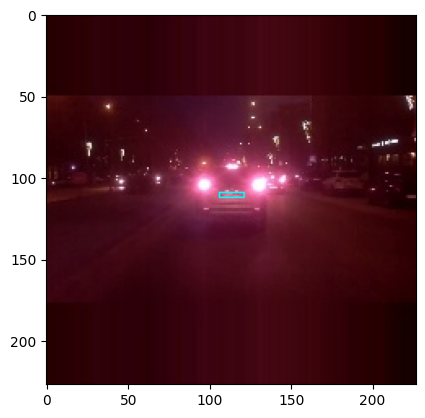

In [33]:
i = 99
# Scale predicted data
predicted_data = [[0.0,0.0,0.0,0.0,0.0]]
predicted_data[0][1] = plates_data_out[i][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][2] = plates_data_out[i][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][3] = plates_data_out[i][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][4] = plates_data_out[i][3] * IMAGE_SHAPE[1]  # ymax


draw_image_with_boxes(plates_data_in[i], predicted_data, border = 1)


## Entrenamiento

In [34]:
# Train the Model
history = model.fit(x = plates_data_in,
                    y = {
                        "box_output": plates_data_out
                    },
                    validation_split=0.2,
                    batch_size = 32, epochs = 500,
                    callbacks=[reduce_lr, stop])
model.save('models/model.h5')

Epoch 1/500


2022-11-16 19:01:05.765246: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102645768 exceeds 10% of free system memory.
2022-11-16 19:01:05.881378: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102645768 exceeds 10% of free system memory.
2022-11-16 19:01:12.776756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 19:01:14.233643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 19:01:14.233703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13970 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


21/21 [==============================] - ETA: 0s - loss: 0.0474 - mse: 0.0474

2022-11-16 19:01:18.183166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 19:01:19.117972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 19:01:19.118023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13970 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


21/21 [==============================] - 15s 341ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0214 - val_mse: 0.0214 - lr: 0.0100
Epoch 2/500
21/21 [==============================] - 3s 163ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0198 - val_mse: 0.0198 - lr: 0.0100
Epoch 3/500
21/21 [==============================] - 3s 160ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0189 - val_mse: 0.0189 - lr: 0.0100
Epoch 4/500
21/21 [==============================] - 3s 162ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0182 - val_mse: 0.0182 - lr: 0.0100
Epoch 5/500
21/21 [==============================] - 3s 122ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0184 - val_mse: 0.0184 - lr: 0.0100
Epoch 6/500
21/21 [==============================] - 3s 159ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0180 - val_mse: 0.0180 - lr: 0.0100
Epoch 7/500
21/21 [==============================] - 2s 118ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0179 - val_mse: 0.0179 - 

KeyboardInterrupt: 

In [ ]:
model.save('models/model.h5')

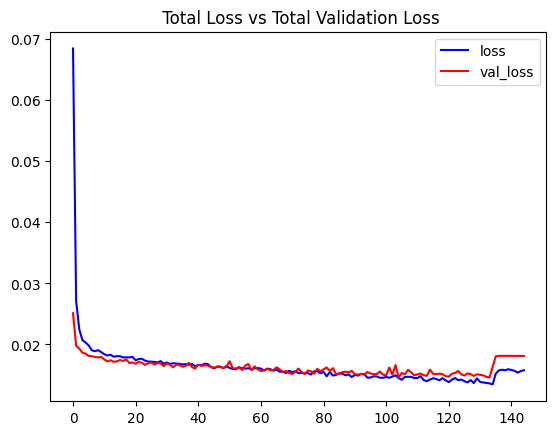

In [ ]:
def plot(var1, var2, plot_name):
    # Get the loss metrics from the trained model
    c1 = history.history[var1]
    c2 = history.history[var2]

    epochs = range(len(c1))

    # Plot the metrics
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.legend()

# plot('box_output_mse','val_box_output_mse','Box Output MSE vs Box Validation MSE')
# plot('box_output_loss','val_box_output_loss','Box Output Loss vs Box Validation Loss')
# These are the most important metrics in telling us how our model is doing
plot('loss','val_loss',' Total Loss vs Total Validation Loss')

## Usar modelo

2022-11-16 22:05:53.723406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 22:05:53.724357: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6650 XT)
2022-11-16 22:05:53.806810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 22:05:53.806860: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-11-16 22:05:53.806889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

1/1 [==============================] - 3s 3s/step
Salida: [[0.348 0.547 0.586 0.626]]


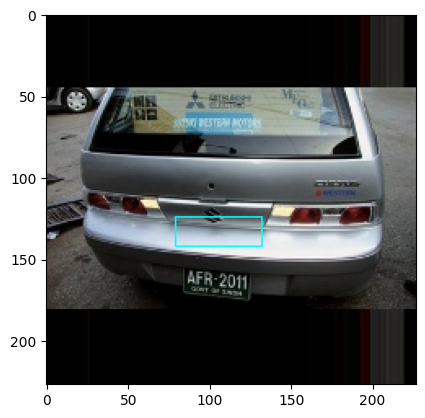

In [4]:


def resize_image(image: np.ndarray, desired_resolution: tuple) -> np.ndarray:
    """
    Resize an image to a given size
    :param image: Image to resize
    :param size: Size to resize to
    :return: Resized image
    """

    # return cv2.resize(image, desired_resolution, interpolation=cv2.INTER_AREA)
    return image


model = models.load_model("./models/model.h5")

input_image = cv2.cvtColor(cv2.imread("/mnt/d/Descargas/test.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
input_image = cv2.cvtColor(cv2.imread("./normalized_data/plates_images/150.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

test_image = np.ndarray(shape=(1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
test_image[0] = resize_image(input_image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))


predicted_data = model.predict(test_image)
print("Salida: " + str(predicted_data))


# Scale predicted data
predicted_data[0][0] = predicted_data[0][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][1] = predicted_data[0][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][2] = predicted_data[0][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][3] = predicted_data[0][3] * IMAGE_SHAPE[1]  # ymax

printable_data = [[0, predicted_data[0][0], predicted_data[0][1], predicted_data[0][2], predicted_data[0][3]]]

# predicted_data[0][1] = 10  # xmin
# predicted_data[0][2] = 10  # ymin
# predicted_data[0][3] = 100  # xmax
# predicted_data[0][4] = 100  # ymax

draw_image_with_boxes(test_image[0], printable_data, border = 1)